In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import json
import requests
import warnings

warnings.filterwarnings('ignore')

In [ ]:
api_key= ""

In [6]:
df= pd.read_csv('task/Ticket Data.txt')
df.head()

,ORDER_NUMBER,ORDER_ID,ORDER_UNIT_ID,ACCEPTANCE_TIME,COMPLETION_TIME,CUSTOMER_NUMBER,CUSTOMER_COUNT,ORDER_TYPE,ORDER_CLASS,PROCESSING_STATUS,...,PROCESSING_END_TIME_MINIMUM,ACCEPTANCE_TIME_MINIMUM,ASSIGNMENT_TIME_MINIMUM,IMIL_TIME_MINIMUM,CUSTOMER_TIME_MINIMUM,START_TIME_MINIMUM,ASSIGNMENT_TIME,ASSIGNED_BY_NAME,ASSIGNMENT_PROCESSING_STATUS,ASSIGNMENT_ADDITIONAL_INFO
0,001-0671177/24,114680574,NaN,11/05/2024 11:00,11/05/2024 11:30,123,3,Short Ticket,SK,Completed,...,11/05/2024 11:00,11/05/2024 11:00,NaN,NaN,11/05/2024 11:00,NaN,NaN,NaN,NaN,NaN
1,001-0682295/24,114691514,NaN,11/05/2024 13:00,11/05/2024 13:45,123,3,Short Ticket,SK,Completed,...,11/05/2024 13:00,11/05/2024 13:00,NaN,NaN,11/05/2024 13:00,NaN,NaN,NaN,NaN,NaN
2,001-0670952/24,114680352,NaN,11/06/2024 08:00,11/06/2024 08:30,123,3,Short Ticket,SK,Completed,...,11/06/2024 08:00,11/06/2024 08:00,NaN,NaN,11/06/2024 08:00,NaN,NaN,NaN,NaN,NaN
3,001-0671369/24,114680756,NaN,11/06/2024 10:00,11/06/2024 10:15,123,3,Short Ticket,SK,Completed,...,11/06/2024 10:00,11/06/2024 10:00,NaN,NaN,11/06/2024 10:00,NaN,NaN,NaN,NaN,NaN
4,001-0670929/24,114680329,NaN,11/06/2024 12:00,11/06/2024 13:00,123,3,Task,SK,Completed,...,11/06/2024 12:00,11/06/2024 12:00,NaN,NaN,11/06/2024 12:00,NaN,NaN,NaN,NaN,NaN


## 1. Ticket Volume and Service Categories

In [ ]:
def create_error_summary(message):
    return {"error": message}

def normalize_order_types_with_openrouter(order_types, model="mistralai/mistral-7b-instruct"):
    prompt = (
        "These are customer order types in various languages or formats. "
        "Please map them to a set of consistent English category labels. "
        "Return a JSON dictionary where keys are the original entries, and values are the normalized English categories.\n\n"
        f"{order_types}"
    )

    headers = {
        "Authorization": "Bearer " + api_key,
        "Content-Type": "application/json",
    }

    payload = {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    }
                ]
            }
        ]
    }

    try:
        response = requests.post(
            url="https://openrouter.ai/api/v1/chat/completions",
            headers=headers,
            data=json.dumps(payload),
            timeout=60
        )

        if response.status_code == 200:
            result = response.json()
            if 'choices' in result and len(result['choices']) > 0:
                content = result['choices'][0]['message']['content']
                content = content.replace('```json', '').replace('```', '').strip()
                try:
                    parsed_json = json.loads(content)
                    return parsed_json, False
                except json.JSONDecodeError as e:
                    return create_error_summary(f"Failed to parse OpenRouter response: {str(e)}"), True
            else:
                return create_error_summary("No valid content in OpenRouter response"), True
        else:
            return create_error_summary(f"OpenRouter Error: {response.status_code} - {response.text}"), True

    except Exception as e:
        return create_error_summary(f"Request failed: {str(e)}"), True


### Normalize ORDER_TYPE as it has same categories but in different languages

In [8]:
unique_order_types = df['ORDER_TYPE'].dropna().unique().tolist()
order_type_mapping, has_error = normalize_order_types_with_openrouter(unique_order_types)

if not has_error:
    df['ORDER_TYPE_NORMALIZED'] = df['ORDER_TYPE'].map(order_type_mapping)
else:
    print("Error:", order_type_mapping)

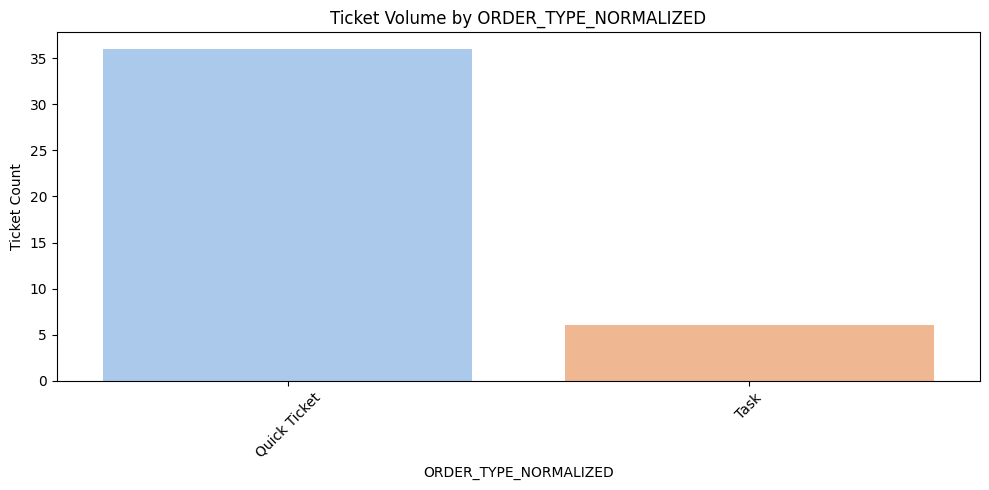

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='ORDER_TYPE_NORMALIZED', order=df['ORDER_TYPE_NORMALIZED'].value_counts().index, palette='pastel')
plt.title('Ticket Volume by ORDER_TYPE_NORMALIZED')
plt.ylabel('Ticket Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Percentage share of top categories
order_type_pct = df['ORDER_TYPE_NORMALIZED'].value_counts(normalize=True) * 100

## 2. Resolution Time Efficiency

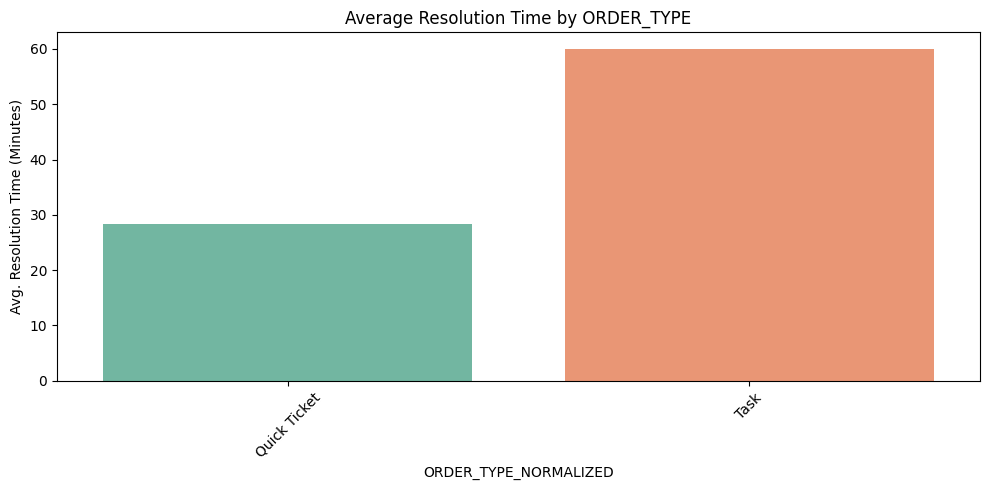

In [11]:
df['ACCEPTANCE_TIME'] = pd.to_datetime(df['ACCEPTANCE_TIME'])
df['COMPLETION_TIME'] = pd.to_datetime(df['COMPLETION_TIME'])

# Calculate resolution time as timedelta
df['resolution_time'] = df['COMPLETION_TIME'] - df['ACCEPTANCE_TIME']

# Convert to minutes
df['resolution_time_minutes'] = df['resolution_time'].dt.total_seconds() / 60

# Group by ORDER_TYPE
resolution_stats = df.groupby('ORDER_TYPE_NORMALIZED')['resolution_time_minutes'].mean().sort_values()

plt.figure(figsize=(10, 5))
sns.barplot(x=resolution_stats.index, y=resolution_stats.values, palette='Set2')
plt.title('Average Resolution Time by ORDER_TYPE')
plt.ylabel('Avg. Resolution Time (Minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

## 3. Customer-Specific Trends

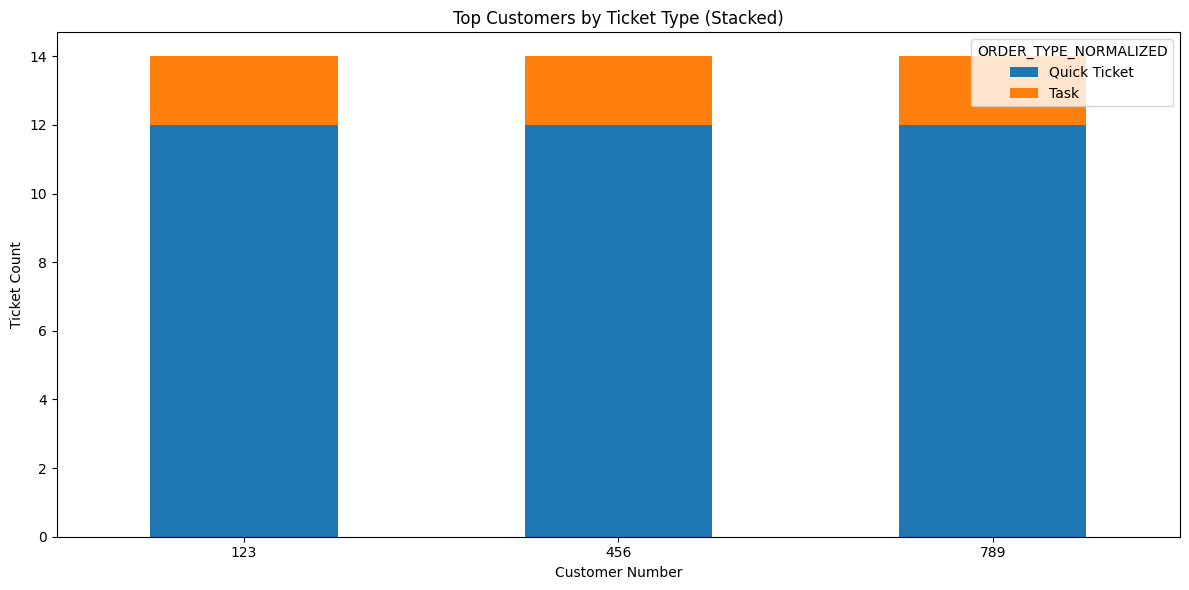

In [12]:
import matplotlib.pyplot as plt

# Top customers by ticket volume
customer_volume = df['CUSTOMER_NUMBER'].value_counts().head(5)
top_customers = customer_volume.index.tolist()
subset = df[df['CUSTOMER_NUMBER'].isin(top_customers)]

# Create pivot table: rows = CUSTOMER_NUMBER, columns = ORDER_TYPE, values = counts
stacked_data = subset.pivot_table(index='CUSTOMER_NUMBER',
                                   columns='ORDER_TYPE_NORMALIZED',
                                   aggfunc='size',
                                   fill_value=0)

# Plot as stacked bar chart
stacked_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Top Customers by Ticket Type (Stacked)')
plt.ylabel('Ticket Count')
plt.xlabel('Customer Number')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 4. Root Causes and Solutions

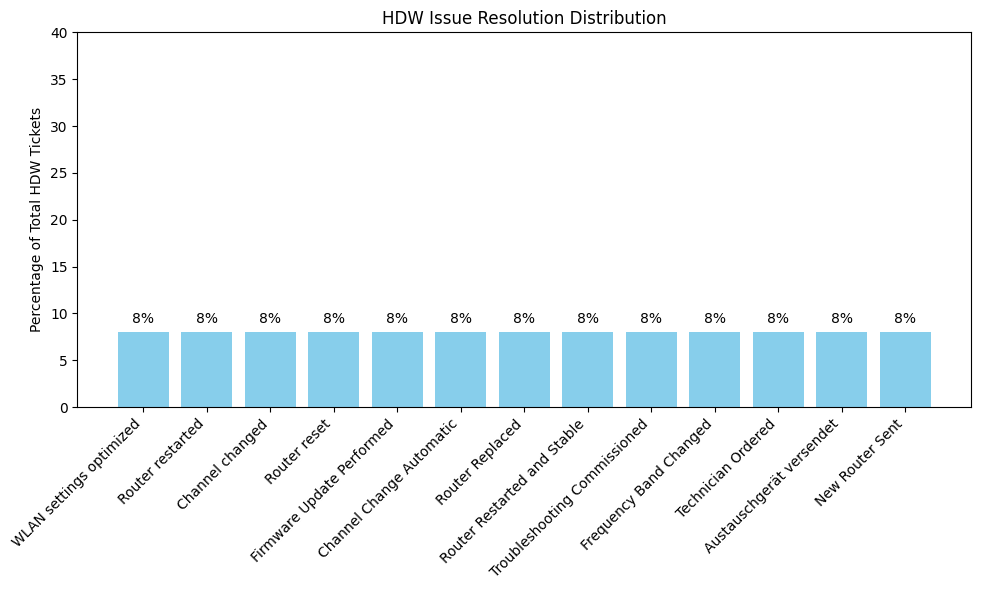

In [13]:
hdw = df[df['SERVICE_CATEGORY'] == 'HDW']
sop = df[df['SERVICE_CATEGORY'] == 'SOP']

# 1. HDW Fix Analysis
hdw_fixes = hdw['COMPLETION_RESULT_KB'].value_counts(normalize=True).mul(100).round(0)
hdw_fixes = hdw_fixes.rename_axis('Fix').reset_index(name='Percentage')

plt.figure(figsize=(10,6))
plt.bar(hdw_fixes['Fix'], hdw_fixes['Percentage'], color='skyblue')
plt.title('HDW Issue Resolution Distribution')
plt.ylabel('Percentage of Total HDW Tickets')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(hdw_fixes['Percentage']):
    plt.text(i, v+1, f"{int(v)}%", ha='center')
plt.ylim(0, 40)
plt.tight_layout()
plt.show()

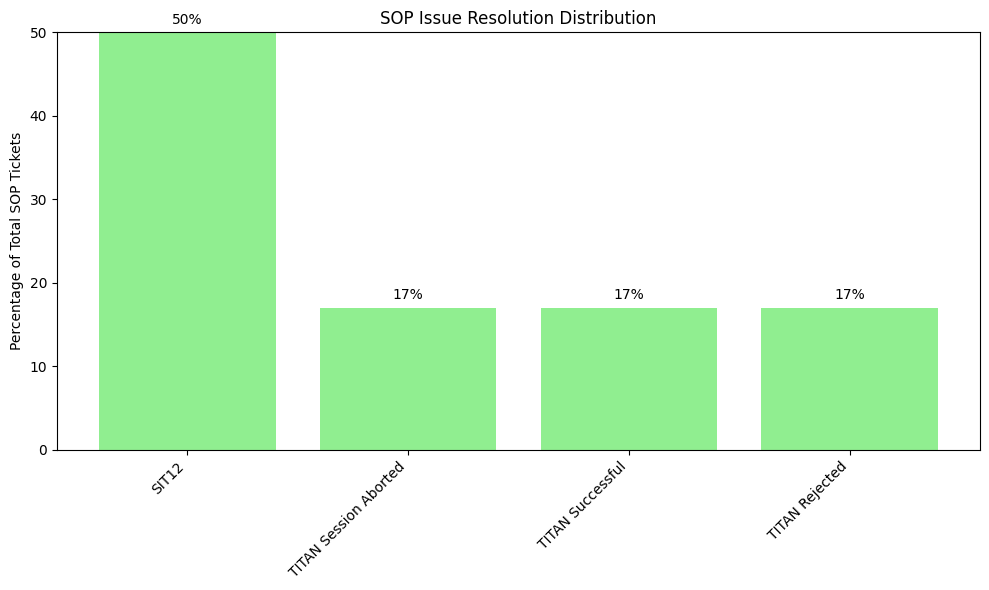

In [ ]:
sop_fixes = sop['COMPLETION_RESULT_KB'].value_counts(normalize=True).mul(100).round(0)
sop_fixes = sop_fixes.rename_axis('Fix').reset_index(name='Percentage')

plt.figure(figsize=(10,6))
plt.bar(sop_fixes['Fix'], sop_fixes['Percentage'], color='lightgreen')
plt.title('SOP Issue Resolution Distribution')
plt.ylabel('Percentage of Total SOP Tickets')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(sop_fixes['Percentage']):
    plt.text(i, v+1, f"{int(v)}%", ha='center')
plt.ylim(0, 50)
plt.tight_layout()
plt.show()

### Classify ticket discription semantically

In [19]:
def classify_ticket_descriptions(descriptions, model="mistralai/mistral-7b-instruct"):
    prompt = (
        "Classify each of the following support ticket descriptions into high-level issue categories like:\n"
        "- WLAN Issue\n"
        "- Modem Activation Issue\n"
        "- Billing Issue\n"
        "- Hardware Issue\n"
        "- Other\n\n"
        "Return a JSON dictionary where the keys are the original descriptions and the values are the categories.\n\n"
        f"{descriptions}"
    )

    headers = {
        "Authorization": "Bearer " + api_key,
        "Content-Type": "application/json",
    }

    payload = {
        "model": model,
        "messages": [
            {
                "role": "user",
                "content": [{"type": "text", "text": prompt}]
            }
        ]
    }

    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        data=json.dumps(payload),
        timeout=60
    )

    if response.status_code == 200:
        content = response.json()['choices'][0]['message']['content']
        content = content.replace('```json', '').replace('```', '').strip()
        return json.loads(content)
    else:
        print(f"Error from OpenRouter: {response.status_code}")
        return {}
    
sample_descriptions = df['ORDER_DESCRIPTION_3_MAXIMUM'].dropna().unique().tolist()
desc_category_mapping = classify_ticket_descriptions(sample_descriptions)

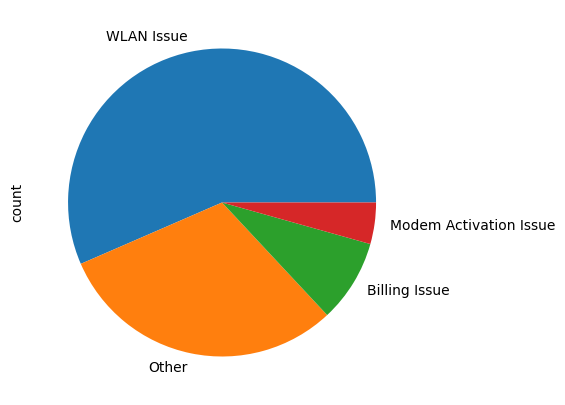

In [ ]:
df['ISSUE_CATEGORY'] = df['ORDER_DESCRIPTION_3_MAXIMUM'].map(desc_category_mapping)
df['ISSUE_CATEGORY'].value_counts().plot(kind='pie', figsize=(10, 5), color='salmon');

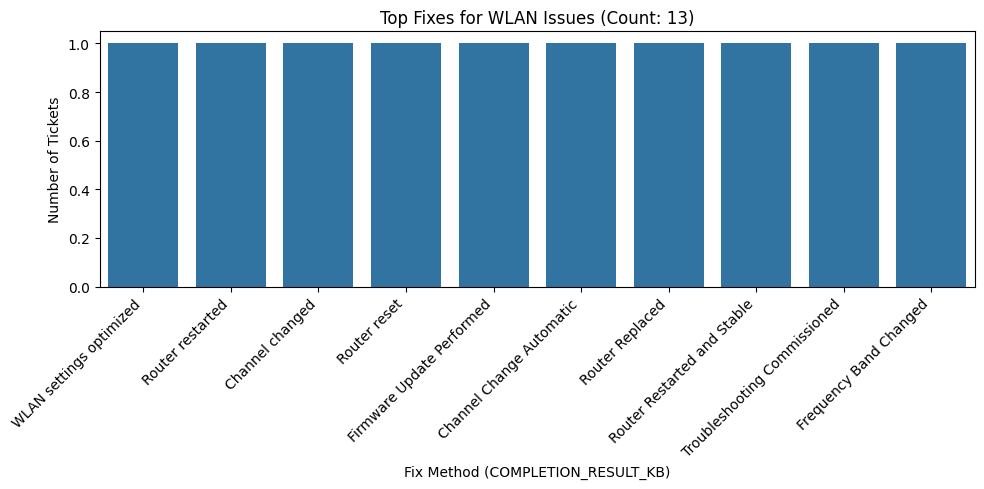

In [29]:
wlan_issues = df[df['ISSUE_CATEGORY'] == 'WLAN Issue']
wlan_fix_counts = wlan_issues['COMPLETION_RESULT_KB'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=wlan_fix_counts.index[:10], y=wlan_fix_counts.values[:10])
plt.title(f"Top Fixes for WLAN Issues (Count: {len(wlan_issues)})")
plt.ylabel("Number of Tickets")
plt.xlabel("Fix Method (COMPLETION_RESULT_KB)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 5. Team Performance

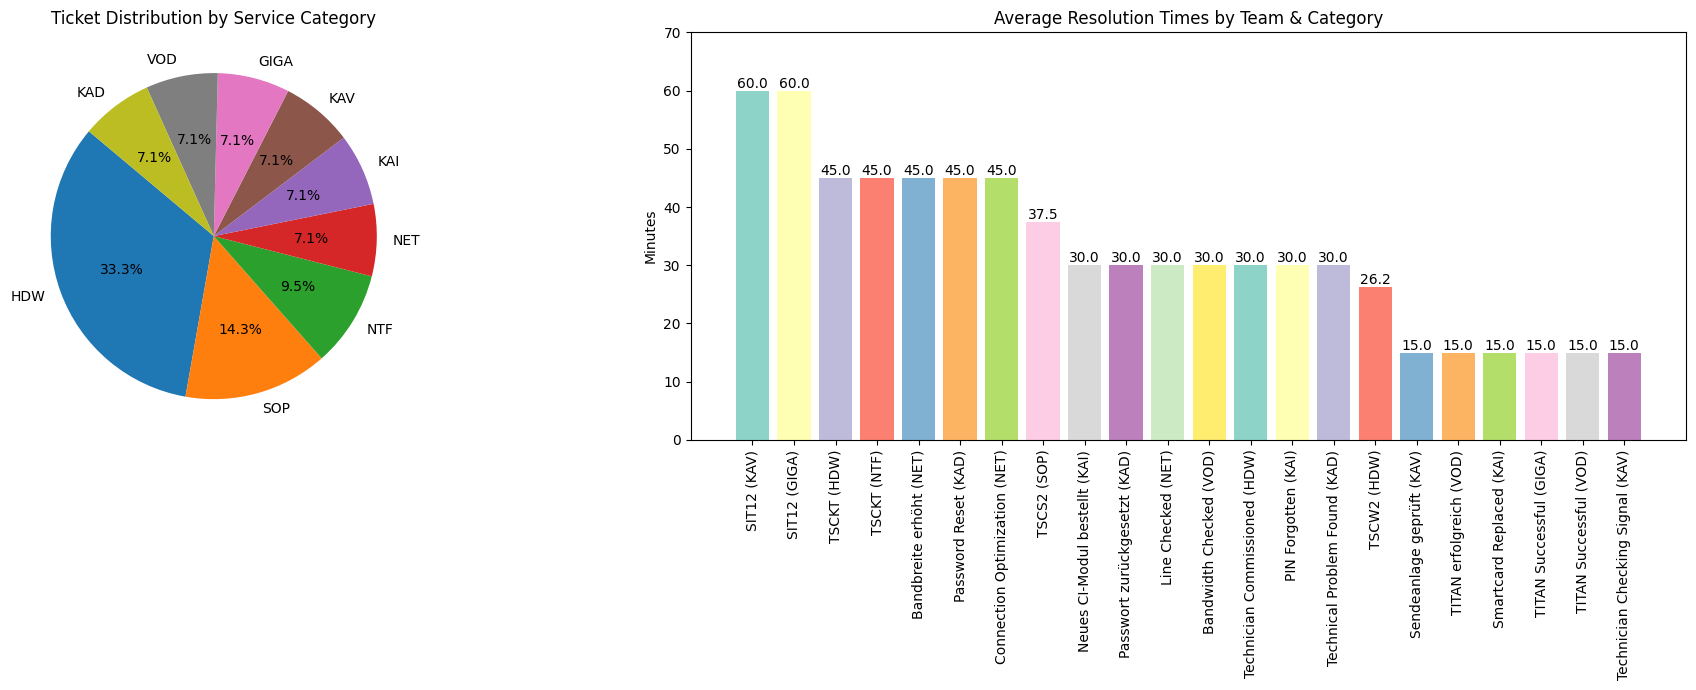

In [40]:
# Sample structure simulation (you would replace this with your real DataFrame `df_copy`)
df_copy = df.copy()
df_copy['resolution_time'] = (df_copy['COMPLETION_TIME'] - df_copy['ACCEPTANCE_TIME']).dt.total_seconds() / 60  # in minutes

# Drop rows with NaT or missing values in resolution_time
df_copy = df_copy.dropna(subset=['resolution_time'])

# Unique planning groups and categories of interest
planning_groups = df_copy['PLANNING_GROUP_KB'].unique()
service_categories = df_copy['SERVICE_CATEGORY'].unique()  # Automatically getting all service categories

# Prepare lists for bar chart data
team_labels = []
avg_times = []

# Pie chart for all categories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Prepare pie chart data for each service category
category_counts = df_copy['SERVICE_CATEGORY'].value_counts(normalize=True) * 100

# Pie chart: Share of each service category
labels = category_counts.index.tolist()
sizes = category_counts.values
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax1.set_title('Ticket Distribution by Service Category')

# Bar chart: Average resolution time for each planning group in each service category
for group in planning_groups:
    for category in service_categories:
        subset = df_copy[(df_copy['PLANNING_GROUP_KB'] == group) & (df_copy['SERVICE_CATEGORY'] == category)]
        if not subset.empty:
            team_labels.append(f"{group} ({category})")
            avg_times.append(subset['resolution_time'].mean())

# Sort by average resolution time (in descending order)
sorted_labels, sorted_avg_times = zip(*sorted(zip(team_labels, avg_times), key=lambda x: x[1], reverse=True))

# Plotting the sorted bar chart
bars = ax2.bar(sorted_labels, sorted_avg_times, color=plt.cm.Set3.colors[:len(sorted_labels)])
ax2.set_title('Average Resolution Times by Team & Category')
ax2.set_ylabel('Minutes')
ax2.set_ylim(0, max(sorted_avg_times) + 10)
ax2.tick_params(axis='x', rotation=90)

# Annotate bars with the average resolution time values
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 6. Temporal Trends

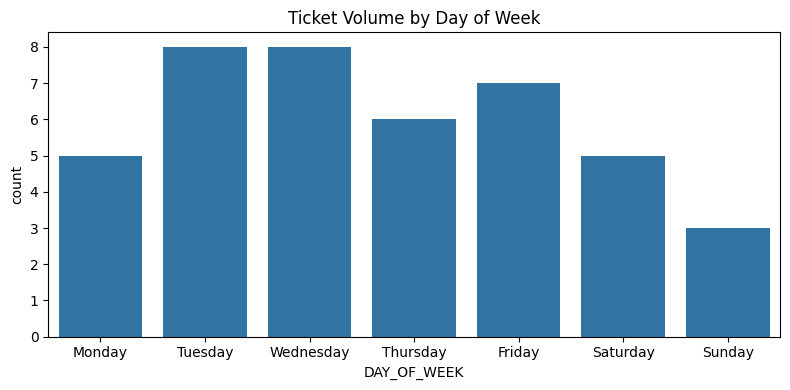

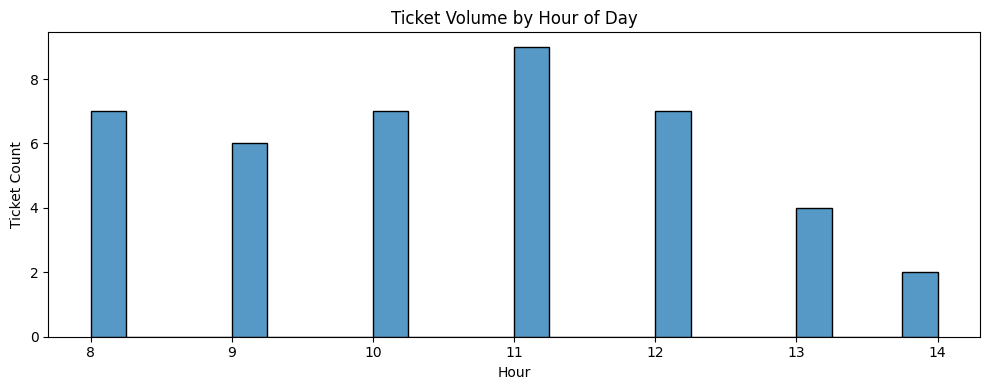

In [42]:
# Day of Week Trend
df['DAY_OF_WEEK'] = df['ACCEPTANCE_TIME'].dt.day_name()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='DAY_OF_WEEK', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Ticket Volume by Day of Week')
plt.tight_layout()
plt.show()

# Time of Day
df['HOUR'] = df['ACCEPTANCE_TIME'].dt.hour

plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='HOUR', bins=24, kde=False)
plt.title('Ticket Volume by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Ticket Count')
plt.tight_layout()
plt.show()

## 7. Error and Escalation Analysis

In [54]:
def classify_ticket(ticket_description, model="mistralai/mistral-7b-instruct"):
    headers = {
        "Authorization": "Bearer " + api_key,
        "Content-Type": "application/json",
    }
    prompt = f"Classify this ticket description into one of the following categories: [Error, Success, Technician Escalated, Unknown]. Description: {ticket_description}\
          be concise return ONLY a class NEVER give any clarification needed. If blank, nan, or unclear classify as Unknown"

    payload = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }

    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",  # OpenRouter API endpoint
        headers=headers,
        data=json.dumps(payload),
        timeout=60
    )

    if response.status_code == 200:
        result = response.json()
        content = result['choices'][0]['message']['content'].strip()
        return content
    else:
        return None

df['completion_category'] = df['COMPLETION_RESULT_KB'].apply(classify_ticket)

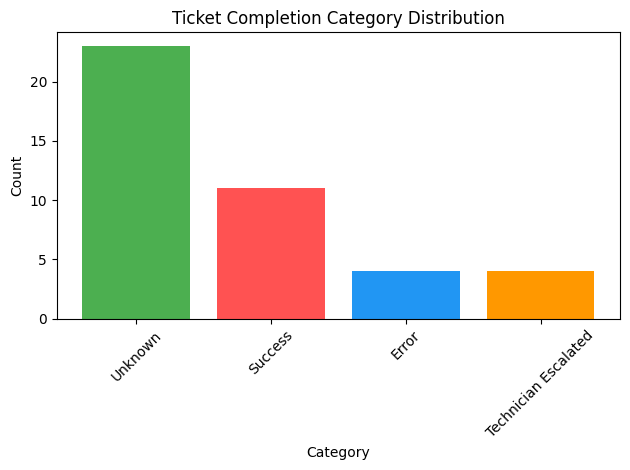

In [57]:
category_counts = df['completion_category'].value_counts(sort=True)
category_labels = category_counts.index
category_values = category_counts.values

plt.bar(category_labels, category_values, color=['#4CAF50', '#FF5252', '#2196F3', '#FF9800'])
plt.title('Ticket Completion Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()